In [54]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [55]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
df_Train = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/vgsales1.csv', sep=',') 
df_Train.head()

,Rank,Name,Platform,Year,Global_Sales
0,1,Wii Sports,Wii,2006,82.74
1,2,Super Mario Bros.,NES,1985,40.24
2,3,Mario Kart Wii,Wii,2008,35.82
3,4,Wii Sports Resort,Wii,2009,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996,31.37


In [56]:
df_Train.tail()

,Rank,Name,Platform,Year,Global_Sales
16593,16596,Woody Woodpecker in Crazy Castle 5,GBA,2002,0.01
16594,16597,Men in Black II: Alien Escape,GC,2003,0.01
16595,16598,SCORE International Baja 1000: The Official Game,PS2,2008,0.01
16596,16599,Know How 2,DS,2010,0.01
16597,16600,Spirits & Spells,GBA,2003,0.01


In [57]:
df_Train.isnull().sum()

Rank            0
Name            0
Platform        0
Year            0
Global_Sales    0
dtype: int64

In [58]:
df_Train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          16598 non-null  int64  
 1   Name          16598 non-null  object 
 2   Platform      16598 non-null  object 
 3   Year          16598 non-null  int64  
 4   Global_Sales  16598 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 648.5+ KB


In [59]:
x = df_Train['Year'].values
y = df_Train['Global_Sales'].values

In [60]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

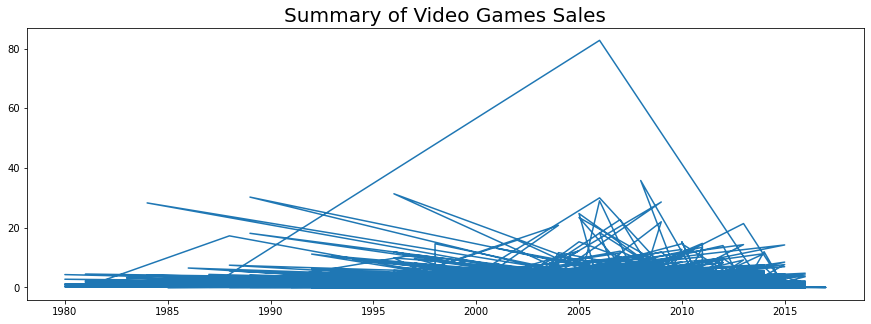

In [61]:
plt.figure(figsize=(15,5))
plt.plot(x_train, y_train)
plt.title('Summary of Video Games Sales',
          fontsize=20);

In [62]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Total")
    plt.grid(True)

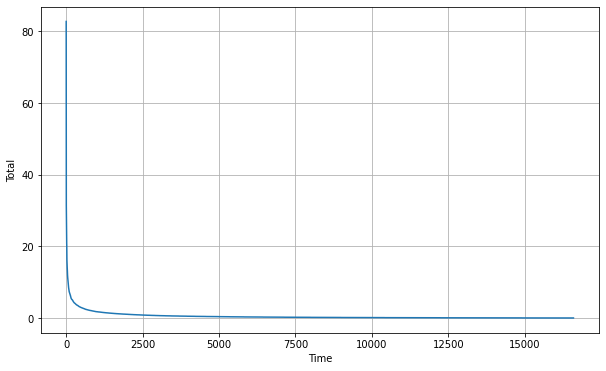

In [65]:
import csv
time_step = []
temps = []

with open('/content/gdrive/My Drive/Colab Notebooks/vgsales1.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[4]))
    time_step.append(step)
    step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [66]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [67]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [68]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [70]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=50, callbacks=[lr_schedule])

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/50
10/10 [==============================] - 0s 18ms/step - loss: 3.7131 - mae: 4.1866
Epoch 2/50
10/10 [==============================] - 0s 22ms/step - loss: 3.6540 - mae: 4.1254
Epoch 3/50
10/10 [==============================] - 0s 23ms/step - loss: 3.5715 - mae: 4.0393
Epoch 4/50
10/10 [==============================] - 0s 22ms/step - loss: 3.4835 - mae: 3.9478
Epoch 5/50
10/10 [==============================] - 0s 23ms/step - loss: 3.3957 - mae: 3.8587
Epoch 6/50
10/10 [==============================] - 0s 22ms/step - loss: 3.3158 - mae: 3.7783
Epoch 7/50
10/10 [==============================] - 0s 24ms/step - loss: 3.2463 - mae: 3.7057
Epoch 8/50
10/10 [==============================] - 0s 24ms/step - loss: 3.1907 - mae: 3.6450
Epoch 9/50
10/10 [==============================] - 0s 25ms/step - loss: 3.1444 - mae: 3.5917
Epoch 10/50
10/10 [==============================] -